In [174]:
#импортируем модули
import pandas as pd
import pandahouse as ph
import seaborn as sns
import numpy as np
import ast
import matplotlib as plt

In [6]:
#делаем подключение к базе данных sql clickhouse
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database': 'default', 
                      'user': 'student',
                      'password': 'dpo_python_2020'
                     }

In [7]:
#делаем другое подключение
connection_test = dict(database='test',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student-rw',
                  password='656e2b0c9c')

In [40]:
#делаем тестовый запрос с таблицы ldn_listings
q = '''
    SELECT
        COUNT(*)
    FROM ldn_listings
    '''

In [13]:
#берем датафрейм с запросом и соединением, сделанными ранее
q_test = ph.read_clickhouse(query=q, connection=connection_default)

In [14]:
#получаем результат
q_test

,count()
0,85207


In [26]:
#делаем запрос sql
q2 = '''
    SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,

    toFloat32OrNull(review_scores_rating) AS review_scores_rating
    
    
    FROM ldn_listings

    WHERE review_scores_rating > 0


    ORDER BY id 

    LIMIT 1000
    '''

In [27]:
#соединияем
q_1 = ph.read_clickhouse(query=q2, connection=connection_default)

In [35]:
#получаем средние значения по типу жилья
data = q_1.groupby('room_type', as_index=False) \
    .agg({'price':'mean', 'review_scores_rating':'mean'}).round(2)

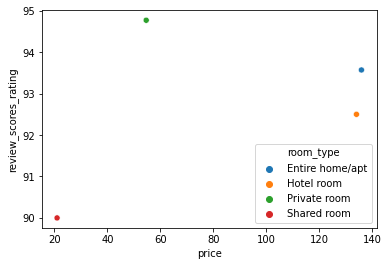

In [39]:
#делаем график рассеивания
sns.scatterplot(data=data, x="price", y="review_scores_rating", hue='room_type')

Задание

Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.

Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:

host_id – идентификатор хозяина (уникальный)
host_verifications – какими способами хост подтвердил свой профиль
Затем обработайте столбец host_verifications:

В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 
"['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']


2. Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации

Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [110]:
q_3 = '''
    SELECT
        DISTINCT host_id,
        host_verifications
    
    FROM 
        ldn_listings

    WHERE 
        experiences_offered != 'none'

    
    '''

In [111]:
data_offer = ph.read_clickhouse(query=q_3, connection=connection_default) 

In [112]:
data_offer

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [90]:
#меняем тип object на array
#data_offer.host_verifications = data_offer.host_verifications.apply(ast.literal_eval)

In [113]:
data_offer.host_verifications = data_offer.host_verifications.apply(lambda x:x.strip('[]').replace(' ', '').split(','))

In [107]:
data_offer.host_verifications[0]

["'email'",
 "'phone'",
 "'facebook'",
 "'reviews'",
 "'offline_government_id'",
 "'selfie'",
 "'government_id'"]

In [114]:
data_offer.explode('host_verifications').host_verifications.value_counts()

'phone'                    1361
'email'                    1345
'reviews'                  1309
'government_id'            1196
'jumio'                    1115
'offline_government_id'     469
'work_email'                279
'facebook'                  270
'selfie'                    252
'identity_manual'           227
'manual_offline'             70
'google'                     34
'kba'                        27
'manual_online'              16
'sent_id'                     6
Name: host_verifications, dtype: int64

Задание 
Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count.

Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True). 

In [125]:
q_4 = '''
SELECT
    neighbourhood_cleansed,
    experiences_offered,
    host_id
    
    
FROM ldn_listings

WHERE experiences_offered != 'none'


'''

In [126]:
data_exp = ph.read_clickhouse(query=q_4, connection=connection_default) 

In [136]:
data_exp_upd = data_exp.groupby(['neighbourhood_cleansed', 'experiences_offered'], as_index=False)\
    .agg({'host_id':'count'}) \
    .rename(columns={'host_id':'experiences_count'})

In [139]:
data_exp_upd = data_exp_upd.sort_values(by='experiences_count', ascending=False)

In [140]:
data_exp_upd.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
36,Hackney,family,61
98,Tower Hamlets,business,58
109,Westminster,business,50
38,Hackney,social,49
39,Hammersmith and Fulham,business,48


In [142]:
data_pivot = data_exp_upd.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')

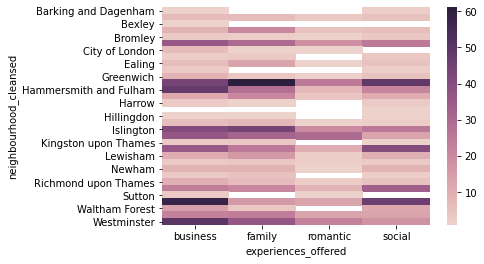

In [143]:
sns.heatmap(data=data_pivot,cmap=sns.cubehelix_palette(as_cmap=True))

Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь 
experiences_offered – вид доступного впечатления (оставить не 'none')


Далее постройте два графика, используя distplot из библиотеки seaborn:

На первом отобразите исходные распределения цен для каждого типа жилья
На втором – логарифмированные значения (np.log())

In [178]:
q_5 = '''
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
    
    
FROM ldn_listings

WHERE experiences_offered != 'none'


'''

In [157]:
data_price = ph.read_clickhouse(query=q_5, connection=connection_default) 

In [154]:
# data_price.groupby('room_type',as_index=False) \
# .agg({'price':'sum'})

SyntaxError: invalid syntax (<ipython-input-154-1371672a2dd6>, line 1)

In [167]:
data_price.room_type.unique()

array(['Private room', 'Entire home/apt', 'Hotel room', 'Shared room'],
      dtype=object)

TypeError: 'module' object is not callable

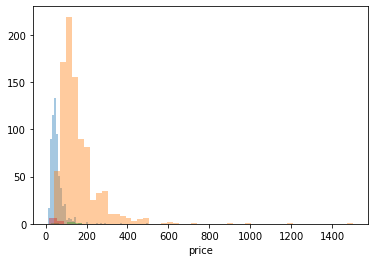

In [176]:
sns.distplot(data_price.query('room_type=="Private room"').price, kde=False, label='Private')
sns.distplot(data_price.query('room_type=="Entire home/apt"').price, kde=False, label='Entire')
sns.distplot(data_price.query('room_type=="Hotel room"').price, kde=False, label='Hotel')
sns.distplot(data_price.query('room_type=="Shared room"').price, kde=False, label='Shared')
plt.legend()
plt.show()

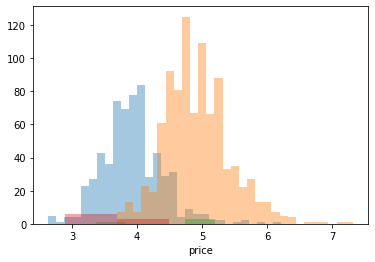

In [171]:
sns.distplot(np.log(data_price.query('room_type=="Private room"').price), kde=False)
sns.distplot(np.log(data_price.query('room_type=="Entire home/apt"').price), kde=False)
sns.distplot(np.log(data_price.query('room_type=="Hotel room"').price), kde=False)
sns.distplot(np.log(data_price.query('room_type=="Shared room"').price), kde=False)


Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь
first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")
Ограничение поставьте на 1000 строк.



Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.


Hints: line plot; удалите последние 6 символов у значений в столбце даты, чтобы получить год, например, с помощью применения lambda-функции .

In [185]:
q_6 = '''
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price ,
    first_review
    
    
FROM ldn_listings

WHERE 
    
    first_review > '2010-01-01'

LIMIT 1000
'''

In [186]:
data_date = ph.read_clickhouse(query=q_6, connection=connection_default) 

In [191]:
data_date.first_review = pd.DatetimeIndex(data_date['first_review']).year

In [194]:
data_date = data_date.rename(columns={'first_review':'year'})

In [200]:
data_date_upd = data_date.groupby(['room_type','year'], as_index=False) \
    .agg({'price':'mean'})  \
    .sort_values(by=['year'])

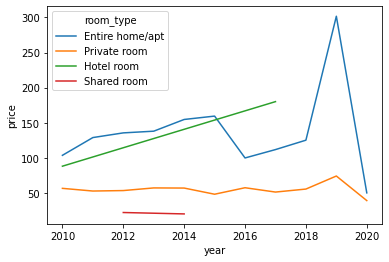

In [202]:

sns.lineplot(x='year',y='price',hue='room_type',data=data_date_upd)